<table class="tfo-notebook-buttons" align="center">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/practicaldl/Practical-Deep-Learning-Book/blob/master/code/chapter-4/3-reduce-feature-length-with-pca.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/practicaldl/Practical-Deep-Learning-Book/blob/master/code/chapter-4/3-reduce-feature-length-with-pca.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

This code is part of [Chapter 4 - Building a Reverse Image Search Engine: Understanding Embeddings](https://learning.oreilly.com/library/view/practical-deep-learning/9781492034858/ch04.html).

Note: In order to run this notebook on Google Colab you need to [follow these instructions](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb#scrollTo=WzIRIt9d2huC) so that the local data such as the images are available in your Google Drive.

# Improving the speed of feature extraction and similarity search

We will experiment with PCA and figure out what is the optimum length of the features to use in our experiments.

## Reduce feature length with PCA

PCA (short for Principal Component Analysis) is a statistical procedure that questions if features representing the data are equally important. Are some of the features redundant enough that we can get similar results on say classification even after removing those features? PCA is considered one of the go-to techniques for dimensionality reduction. Note that it does not eliminate redundant features, instead it generates a new set of features that are a linear combination of the input features. These linear features are orthogonal to each other, which is why all the redundant features are absent. These features are known as principal components. 


Performing PCA is pretty simple, using the scikit-learn library.

In [1]:
import numpy as np
import pickle
from tqdm import tqdm, tqdm_notebook
import random
import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import PIL
from PIL import Image
from sklearn.neighbors import NearestNeighbors
import random
import glob

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
matplotlib.rcParams['savefig.dpi'] = 160
matplotlib.rcParams['figure.dpi'] = 160
%matplotlib notebook

You can run the following code on either the Caltech101 or the Caltech256 dataset. Run either one of the following two blocks of code to load the desired dataset.

In [2]:
filenames = pickle.load(open('data/filenames-caltech101.pickle', 'rb'))
feature_list = pickle.load(open('data/features-caltech101-resnet.pickle', 'rb'))
class_ids = pickle.load(open('data/class_ids-caltech101.pickle', 'rb'))

In [3]:
'''
filenames = pickle.load(open('data/filenames-caltech256.pickle', 'rb'))
feature_list = pickle.load(open('data/features-caltech256-resnet-finetuned.pickle', 'rb'))
class_ids = pickle.load(open('data/class_ids-caltech256.pickle', 'rb'))
'''

"\nfilenames = pickle.load(open('data/filenames-caltech256.pickle', 'rb'))\nfeature_list = pickle.load(open('data/features-caltech256-resnet-finetuned.pickle', 'rb'))\nclass_ids = pickle.load(open('data/class_ids-caltech256.pickle', 'rb'))\n"

In [4]:
num_images = len(filenames)
num_features_per_image = len(feature_list[0])
print("Number of images = ", num_images)
print("Number of features per image = ", num_features_per_image)

Number of images =  8677
Number of features per image =  2048


In [5]:
# Helper function to get the classname
def classname(str):
    return str.split('/')[-2]


# Helper function to get the classname and filename
def classname_filename(str):
    return str.split('/')[-2] + '/' + str.split('/')[-1]


# Helper function that calculates accuracy using the nearest neighbors brute force algorithm
def calculate_accuracy(feature_list):
    num_nearest_neighbors = 5
    correct_prediction = 0
    incorrect_prediction = 0
    neighbors = NearestNeighbors(n_neighbors=num_nearest_neighbors,
                                 algorithm='brute',
                                 metric='euclidean').fit(feature_list)
    start = time.time()
    for i in range(len(feature_list)):
        distances, indices = neighbors.kneighbors([feature_list[i]])
        for j in range(1, num_nearest_neighbors):
            if (classname(filenames[i]) == classname(
                    filenames[indices[0][j]])):
                correct_prediction += 1
            else:
                incorrect_prediction += 1
    end = time.time()
    accuracy = round(
        100.0 * correct_prediction /
        (1.0 * correct_prediction + incorrect_prediction), 2), end - start
    return accuracy

In [6]:
print("Accuracy on original feature set : ",
      calculate_accuracy(feature_list[:]))

Accuracy on original feature set :  (100.0, 458.5997567176819)


In [7]:
pca_dimensions = [1, 2, 3, 4, 5, 10, 20, 50, 75, 100, 150, 200]
pca_accuracy = []
pca_time = []

for dimensions in pca_dimensions:
    pca = PCA(n_components=dimensions)
    pca.fit(feature_list)
    feature_list_compressed = pca.transform(feature_list[:])
    # Calculate accuracy over the compressed features
    accuracy, t = calculate_accuracy(feature_list_compressed[:])
    pca_time.append(t)
    pca_accuracy.append(accuracy)
    print("For PCA Dimensions = ", dimensions, ",\tAccuracy = ", accuracy, "%",
          ",\tTime = ", pca_time[-1])

For PCA Dimensions =  1 ,	Accuracy =  100.0 % ,	Time =  5.27965235710144
For PCA Dimensions =  2 ,	Accuracy =  100.0 % ,	Time =  5.370832681655884
For PCA Dimensions =  3 ,	Accuracy =  100.0 % ,	Time =  5.407890796661377
For PCA Dimensions =  4 ,	Accuracy =  100.0 % ,	Time =  5.4138360023498535
For PCA Dimensions =  5 ,	Accuracy =  100.0 % ,	Time =  5.553959608078003
For PCA Dimensions =  10 ,	Accuracy =  100.0 % ,	Time =  5.760199069976807
For PCA Dimensions =  20 ,	Accuracy =  100.0 % ,	Time =  6.046750545501709
For PCA Dimensions =  50 ,	Accuracy =  100.0 % ,	Time =  7.664635419845581
For PCA Dimensions =  75 ,	Accuracy =  100.0 % ,	Time =  9.068251848220825
For PCA Dimensions =  100 ,	Accuracy =  100.0 % ,	Time =  14.712860584259033
For PCA Dimensions =  150 ,	Accuracy =  100.0 % ,	Time =  21.553019285202026
For PCA Dimensions =  200 ,	Accuracy =  100.0 % ,	Time =  29.127892017364502


Let's plot the test time accuracy for each PCA dimension.

In [8]:
f = plt.figure()

# matplotlib.style.use('seaborn')
plt.plot(pca_time, pca_accuracy, 'o--', markersize=5)
for label, x, y in zip(pca_dimensions, pca_time, pca_accuracy):
    plt.annotate(label, xy=(x, y), ha='right', va='bottom')
plt.title('Test Time vs Accuracy for each PCA dimension')
plt.xlabel('Test Time')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

f.savefig("pca-test_time_vs_acc.pdf", bbox_inches='tight')
f.savefig("pca-test_time_vs_acc.png", bbox_inches='tight')

<IPython.core.display.Javascript object>

In [9]:
f.savefig('pca-test_time_vs_acc.pdf', bbox_inches='tight')
f.savefig('pca-test_time_vs_acc.png', transparent=False, bbox_inches='tight')

As visible in the graph, there is little improvement in accuracy after increasing beyond feature length of 100 dimensions. With almost 20 times lesser dimensions (100) that the original (2048), this offers drastically higher speed and less time on almost any search algorithm, while getting similar (and sometimes slightly better) accuracy. Hence, 100 would be an ideal feature length for this dataset. This also means that the first 100 dimensions contain the most information about the dataset.


Let's plot the variance of each PCA dimension.

In [10]:
f = plt.figure()

# matplotlib.style.use('seaborn')
plt.plot(range(1, 201), pca.explained_variance_ratio_, 'o--', markersize=3)
plt.title('Variance vs number of PCA dimensions')
plt.xlabel('PCA Dimension Count')
plt.ylabel('Variance')
plt.grid(True)
plt.show()

f.savefig("Variance vs number of PCA dimensions.pdf", bbox_inches='tight')
f.savefig("Variance vs number of PCA dimensions.png", bbox_inches='tight')

<IPython.core.display.Javascript object>

The individual variance will tell us how important the newly added features are. For example, after the first 100 dimensions, the additional dimensions don’t add much variance (almost equal to 0) and can be neglected. Without even checking the accuracy it is safe to assume that the PCA with 100 dimensions will be a  robust model. Another way to look at this is to visualize how much of the original data is explained by the limited number of features by finding the cumulative variance.

### Cumulative Variance vs number of PCA dimensions.

In [11]:
f = plt.figure()

# matplotlib.style.use('seaborn')
plt.plot(range(1, 201),
         pca.explained_variance_ratio_.cumsum(),
         'o--',
         markersize=3)
plt.title('Cumulative Variance vs number of PCA dimensions')
plt.xlabel('PCA Dimension Count')
plt.ylabel('Cumulative Variance')
plt.grid(True)
plt.show()

f.savefig("Cumulative Variance vs number of PCA dimensions.pdf",
          bbox_inches='tight')
f.savefig("Cumulative Variance vs number of PCA dimensions.png",
          bbox_inches='tight')

<IPython.core.display.Javascript object>

As expected adding 100 dimensions (from 100 to 200) adds only .1 variance and starts to gradually plateau. For reference, using full 2048 features would result in a cumulative variance of 1. 


### Plotting the effect of PCA dimension vs Classification Accuracy.

In [12]:
f = plt.figure()

# matplotlib.style.use('seaborn')
plt.plot(pca_dimensions, pca_accuracy, 'o--', markersize=4)
plt.title('Effect of PCA dimension vs Classification Accuracy')
plt.xlabel('PCA Dimensions')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

f.savefig("Effect of PCA dimension vs Classification Accuracy.pdf",
          bbox_inches='tight')
f.savefig("Effect of PCA dimension vs Classification Accuracy.png",
          bbox_inches='tight')

<IPython.core.display.Javascript object>

As visible in the graph, there is little improvement in accuracy after increasing beyond feature length of 100 dimensions. With almost 20 times lesser dimensions (100) that the original (2048), this offers drastically higher speed and less time on almost any search algorithm, while getting similar (and sometimes slightly better) accuracy. Hence 100 would be an ideal feature length for this dataset.

We will now plot the effect of number of PCA dimensions vs time.

In [13]:
f = plt.figure()

# matplotlib.style.use('seaborn')
plt.plot(pca_dimensions, pca_time, 'o--', markersize=4)
plt.title('Effect of PCA dimensions vs Time')
plt.xlabel('PCA Dimension Count')
plt.ylabel('Time')
plt.grid(True)
plt.show()

f.savefig("Effect of PCA dimensions vs Time.pdf", bbox_inches='tight')
f.savefig("Effect of PCA dimensions vs Time.png", bbox_inches='tight')

<IPython.core.display.Javascript object>

Now let's compare different options available for similarity search

In [14]:
num_items = num_images
num_dimensions = 100

In [15]:
dataset = np.random.randn(num_items, num_dimensions)
dataset /= np.linalg.norm(dataset, axis=1).reshape(-1, 1)

In [16]:
randomIndex = random.randint(0, num_items)
query = dataset[randomIndex]

### Brute force

In [17]:
# Time the indexing for the brute force algorithm
%timeit NearestNeighbors(n_neighbors=5, algorithm='brute', metric='euclidean').fit(dataset)

873 µs ± 73.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [18]:
# Time the search for the brute force algorithm
neighbors = NearestNeighbors(n_neighbors=5,
                             algorithm='brute',
                             metric='euclidean').fit(dataset)
%timeit neighbors.kneighbors([query])

688 µs ± 9.84 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### k-d Tree

In [19]:
# Time the indexing for the k-d tree algorithm
%timeit NearestNeighbors(n_neighbors=5, algorithm='kd_tree').fit(dataset)

96.4 ms ± 4.74 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
# Time the search for the k-d tree algorithm
neighbors = NearestNeighbors(n_neighbors=5,
                             algorithm='kd_tree').fit(dataset)
%timeit neighbors.kneighbors([query])

2.37 ms ± 138 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Ball Tree

In [21]:
# Time the indexing for the Ball Tree algorithm
%timeit NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(dataset)

65.4 ms ± 4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
# Time the search for the Ball Tree algorithm
neighbors = NearestNeighbors(n_neighbors=5,
                             algorithm='ball_tree').fit(dataset)
%timeit neighbors.kneighbors([query])

1.94 ms ± 79.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
#!pip3 install annoy

Now we have seen the time it takes to index and search using nearest neighbor algorithms on the full feature length. Now, We will use enhanced searching techniques like Faiss and Annoy to compress the features and reduce the time 

### Annoy

Annoy (Approximate Nearest Neighbors Oh Yeah) is a C++ library with Python bindings for searching nearest neighbors. Synonymous with speed, it was released by Spotify and is used in production to serve their music recommendations. 

To use annoy, install it using pip:  `pip3 install annoy`

In [24]:
from annoy import AnnoyIndex
%matplotlib inline

In [25]:
# Choose a random image to experiment
random_image_index = random.randint(0, num_items)
# Note: the results may change if the image is changed

First, we build a search index with two hyperparameters - the number of dimensions of the dataset, and the number of trees. 

In [26]:
annoy_index = AnnoyIndex(
    num_dimensions)  # Length of item vector that will be indexed
for i in range(num_items):
    annoy_index.add_item(i, dataset[i])
annoy_index.build(40)  #40 trees

C:\Users\Asus\AppData\Local\Temp\ipykernel_32456\1247277472.py:1: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  annoy_index = AnnoyIndex(


True

Now let’s find out the time it takes to search the 5 nearest neighbors of one image.

In [27]:
#u = AnnoyIndex(num_dimensions)
#Time the search for one image for Annoy
%timeit annoy_index.get_nns_by_vector(query, 5, include_distances=True )

48.6 µs ± 580 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Now THAT is blazing fast! To put this in perspective, for such a modestly sized dataset, this can serve almost 15000 requests on a single CPU core. Considering most CPUs have multiple cores, it should be able to handle 100K+ requests on a single system. The best part is that it lets you share the same index in memory between multiple processes. Hence, the biggest index can be equivalent to the size of your overall RAM, making it possible to serve multiple requests on a single system. 

Other benefits include that it generates a modestly sized index. Moreover, it decouples creating indexes from loading them, so you can create an index on one machine, pass it around and then on your serving machine, load it in memory and serve it. 

Let's time the indexing for different number of tree:

In [28]:
annoy_training_time = []
annoy_test_time = []
annoy_trees = [
    1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300
]
for num_trees in annoy_trees:
    t = AnnoyIndex(2048)  # Length of item vector that will be indexed
    for i in range(num_images):
        feature = feature_list[i]
        t.add_item(i, feature)
    start_time = time.time()
    t.build(num_trees)  #50 trees
    end_time = time.time()
    annoy_training_time.append(end_time - start_time)
    start_time = time.time()
    indices = t.get_nns_by_vector(feature_list[random_image_index],
                                  5,
                                  include_distances=True)
    end_time = time.time()
    annoy_test_time.append(end_time - start_time)
    print("For number of trees = ", num_trees, ",\tTime to train = ",
          annoy_training_time[-1], ",\tTime to test = ", annoy_test_time[-1])

C:\Users\Asus\AppData\Local\Temp\ipykernel_32456\3703383969.py:7: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  t = AnnoyIndex(2048)  # Length of item vector that will be indexed


For number of trees =  1 ,	Time to train =  0.0643770694732666 ,	Time to test =  0.0029821395874023438
For number of trees =  2 ,	Time to train =  0.0750575065612793 ,	Time to test =  0.004000425338745117
For number of trees =  3 ,	Time to train =  0.07801699638366699 ,	Time to test =  0.0019989013671875
For number of trees =  4 ,	Time to train =  0.07681417465209961 ,	Time to test =  0.002996206283569336
For number of trees =  5 ,	Time to train =  0.08202409744262695 ,	Time to test =  0.0039997100830078125
For number of trees =  10 ,	Time to train =  0.09060406684875488 ,	Time to test =  0.0030002593994140625
For number of trees =  20 ,	Time to train =  0.2061772346496582 ,	Time to test =  0.0030012130737304688
For number of trees =  30 ,	Time to train =  0.22674226760864258 ,	Time to test =  0.001997232437133789
For number of trees =  40 ,	Time to train =  0.35326409339904785 ,	Time to test =  0.0015056133270263672
For number of trees =  50 ,	Time to train =  0.47088170051574707 ,	Ti

### Effect of number of trees vs Training time

In [29]:
plt.plot(annoy_trees, annoy_training_time, 'or--')
plt.title('Effect of number of trees vs Training time')
plt.xlabel('Number of trees')
plt.ylabel('Training Time')
plt.grid(True)
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Effect of number of trees vs Test time

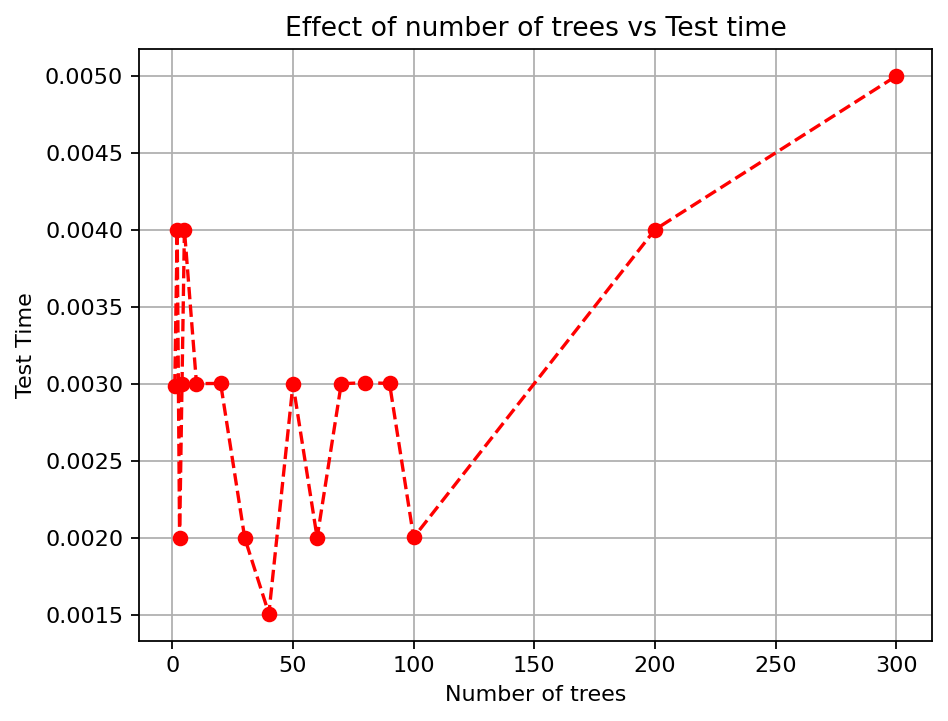

In [30]:
plt.plot(annoy_trees, annoy_test_time, 'or--')
plt.title('Effect of number of trees vs Test time')
plt.xlabel('Number of trees')
plt.ylabel('Test Time')
plt.grid(True)
plt.show()

### NMS Lib

In [31]:
import nmslib

In [32]:
index = nmslib.init(method='hnsw', space='cosinesimil')
index.addDataPointBatch(dataset)
index.createIndex({'post': 2}, print_progress=True)

In [33]:
# query for the nearest neighbors of the first datapoint
%timeit index.knnQuery(query, k=5)
ids, distances = index.knnQuery(query, k=5)

33.2 µs ± 968 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [34]:
# Get all nearest neighbors for all the datapoint
%timeit index.knnQueryBatch(dataset, k=5, num_threads=16)
neighbors = index.knnQueryBatch(dataset, k=5, num_threads=16)

47.7 ms ± 648 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Falconn

In [35]:
# import falconn

In [36]:
# parameters = falconn.LSHConstructionParameters()
# num_tables = 1
# parameters.l = num_tables
# parameters.dimension = num_dimensions
# parameters.distance_function = falconn.DistanceFunction.EuclideanSquared
# parameters.lsh_family = falconn.LSHFamily.CrossPolytope
# parameters.num_rotations = 1
# parameters.num_setup_threads = 1
# parameters.storage_hash_table = falconn.StorageHashTable.BitPackedFlatHashTable
# falconn.compute_number_of_hash_functions(16, parameters)

# index = falconn.LSHIndex(parameters)
# %time index.setup(dataset)

# query_object = index.construct_query_object()
# num_probes = 1
# query_object.set_num_probes(num_probes)

# %timeit query_object.find_k_nearest_neighbors(query, 5)

In [37]:
# query = dataset[5000]
# print(query_object.find_k_nearest_neighbors(query, 5))